In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [13]:
imagePaths = list(paths.list_images("C:/Users/TODAY/VSCode/Jerawat/jerawat/dataset"))
data = []
labels = []

In [14]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath,target_size=(224,224))
	print(image)
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


<PIL.Image.Image image mode=RGB size=224x224 at 0x22469EDBFD0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22465DE4950>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22465CFB390>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22465D24190>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F94E10>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F35850>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F36850>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F36E50>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F2E210>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F2E210>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F34510>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F371D0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F37C90>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F35310>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469F37CD0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x22469

In [15]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [16]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [17]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [19]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [20]:
for layer in baseModel.layers:
	layer.trainable = False

INIT_LR= 1e-4
EPOCHS = 5
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [22]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# Assuming lb is the label binarizer
predIdxs = np.argmax(predIdxs, axis=1)

# Assuming testY is the ground truth labels
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Saving the model to the specified directory with the name "acnedetection.h5"
print("[INFO] saving mask detector model...")
model.save("model.h5", save_format="h5")

[INFO] evaluating network...
4/4 [==============================] - 7s 1s/step
              precision    recall  f1-score   support

     jerawat       0.68      0.21      0.32        62
      normal       0.40      0.85      0.55        39

    accuracy                           0.46       101
   macro avg       0.54      0.53      0.43       101
weighted avg       0.58      0.46      0.41       101

[INFO] saving mask detector model...


c:\Users\TODAY\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2

In [24]:
print("[INFO] loading face detector model...")
prototxtPath = "C:/Users/TODAY/VSCode/AcneDetection/acne_detection/face_detector/deploy.prototxt"
weightsPath = "C:/Users/TODAY/VSCode/AcneDetection/acne_detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)


[INFO] loading face detector model...


In [26]:
print("[INFO] loading face acne detector model...")
model = load_model("C:/Users/TODAY/VSCode/Jerawat/model.h5")


image = cv2.imread("C:/Users/TODAY/VSCode/Jerawat/jerawat/dataset/jerawat/07PerioralDermEye.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()


[INFO] loading face acne detector model...
[INFO] computing face detections...


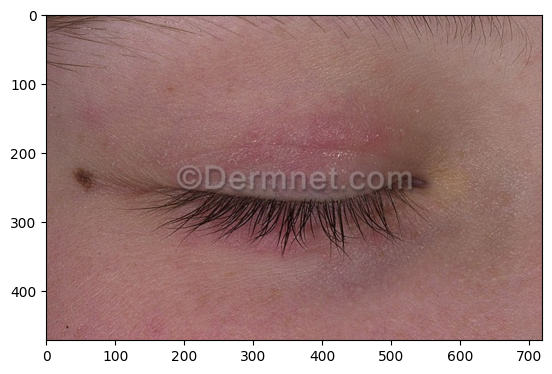

In [27]:
for i in range(0, detections.shape[2]):

	confidence = detections[0, 0, i, 2]


	if confidence > 0.5:

		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")


		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))


		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)


		(acne, withoutAcne) = model.predict(face)[0]


		label = "Acne" if acne > withoutAcne else "No Acne"
		color = (0, 0, 255) if label == "Acne" else (0, 255, 0)

		label = "{}: {:.2f}%".format(label, max(acne, withoutAcne) * 100)

		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)


plt.imshow((cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
plt.show()